# Get GOES
## Create a Machine Learning Ready Dataset From GOES imagery
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reykoki/Get_GOES/blob/main/Get_GOES.ipynb)

![](https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/DayNightCloudMicroCombo/GOES16-CONUS-DayNightCloudMicroCombo-625x375.gif)

* **Notebook Creator:** Rey Koki  rey.koki@noaa.gov (1,2)

* **Affiliations:**
    1. Cooperative Institute for Research for Environmental Sciences ([CIRES](https://cires.colorado.edu/))
    2. NOAA Global Systems Laboratory ([GSL](https://gsl.noaa.gov/))

 
* **Acknowledgements:**
    * funding support for this notebook was provided by NCEI
 
### Overview

**Get GOES** is the first notebook in the series of 3 notebooks that will provide examples of using GOES imagery for deep learning applications. This initial notebook will give a general overview on how to download and save GOES-Series satellite imagery data for machine learning applications. The subsequent notebooks will provide the user with an example application, semantic segmentation of smoke in satellite imagery.

### Learning Objectives

#### The intented outcome of this tutorial is that the user will be able to:
1. Given a date and time, download the corresponding [GOES satellite imagery from AWS](https://registry.opendata.aws/noaa-goes/)
2. From the raw GOES imagery, use SatPy to apply a projection then correct and proccess a True Color composite for the Continental US (CONUS)
3. Visualize CONUS True Color composite imagery
4. Given a location of interest, create a geographically localized image that is appropiately sized for input to a machine learning application
5. Visualize machine learning ready raw and composite imagery

In [2]:
import os
if os.getcwd() == '/content':
    print("You are working in a Google colab notebook!\nLet's grab data and code from github.\n")
    !rm -r Get_GOES scripts figures data
    !git clone https://github.com/reykoki/Get_GOES.git
    !rm Get_GOES/Get_GOES.ipynb
    !mv Get_GOES/* .
    !pip install -r requirements.txt
import matplotlib.pyplot as plt
import numpy as np
import skimage
from glob import glob
from datetime import datetime
import pytz
import pyproj
import sys
sys.path.insert(1, './scripts')
from helper_functions import *

# Develop a Machine Learning Ready Dataset from GOES Satellite Imagery

We will take data from the GOES-EAST Advanced Baseline Imager (ABI) and generate a data sample that is geographically localized for a given latitude and longitude.

## 1. GOES Satellite Imagery

For a comprehensive technical guide to GOES satellites and their instruments, refer to the [GOES-R Series Data Book](https://www.goes-r.gov/downloads/resources/documents/GOES-RSeriesDataBook.pdf).


![GOES-16](https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/GEOCOLOR/GOES16-CONUS-GEOCOLOR-625x375.gif "GOES")


Satellite remote sensors detect light at spectral bands or channels that correspond to a specific range of wavelengths where each band has a set of features it best illustrates. 

The GOES-Series Advanced Baseline Imager (ABI) provides data at 16 channels that cover visible (C01-C02), near-IR (C03-C06) and IR (C07-C16) bands. 


| Band | Description | Center Wavelength ($\mu$m) | Spatial Resolution (km) |
| :-: | :-: | :-: | :-: |
| [C01](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band01.pdf) | Blue visible | 0.47 | 1 |
| [C02](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band02.pdf) | Red visible | 0.64 | 0.5 |
| [C03](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band03.pdf) | Veggie near IR | 0.865 | 1 |
| [C04](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band04.pdf) | Cirrus | 1.378 | 2 |
| [C05](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band05.pdf) | Snow/Ice | 1.61 | 1 |
| [C06](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band06.pdf) | Cloud particle | 2.24 | 2 |
| [C07](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band07.pdf) | Shortwave IR | 3.9 | 2 |
| [C08](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf) | upper-level water vapor | 6.2 | 2 |
| [C09](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf) | mid-level water vapor | 6.9 | 2 |
| [C10](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf) | lower-level water vapor | 7.3 | 2 |
| [C11](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band11.pdf) | IR cloud phase | 8.5 | 2 |
| [C12](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band12.pdf) | ozone | 9.6 | 2 |
| [C13](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band13.pdf) | clean longwave IR | 10.35 | 2 |
| [C14](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf) | longwave IR | 11.2 | 2 |
| [C15](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band15.pdf) | dirty longwave IR | 12.3 | 2 |
| [C16](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band16.pdf) | CO$_2$ | 13.3 | 2 |


A new ABI-L1b-RadC data file is produced every 5 minutes from both GOES-East and GOES-West and provided in netCDF4 format. 

## 1.1. Grab GOES Satellite NetCDF files

From the datetime string, we download all 16 GOES-East band netcdf files from the [AWS repository](https://registry.opendata.aws/noaa-goes/). 

### 1.1.1. Define date and time

Use the format `YYYY/mm/dd HH:MM` to specify the time you'd like to grab imagery for.

In [3]:
dt_str = '2024/06/18 14:00'
dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M')) # convert to datetime object

### 1.1.2. Download the files from AWS

See code in `./scripts/grab_goes.py` for more details on how to use the Python interface for [sfs3](https://github.com/fsspec/s3fs) do this.

For the date given, we print the sunrise time (UTC) on the West coast and sunset on the East coast. If you choose a UTC time within those time bounds, then there should be sunlight at any CONUS geolocation.

In [4]:
from grab_goes import download_goes # ./scripts/grab_goes.py
sat_fns = download_goes(dt)

for the datetime 2024-06-18 14:00:00+00:00:
sunrise is at: 2024-06-18 13:31:12+00:00
sunset is at: 2024-06-18 00:37:48+00:00
OR_ABI-L1b-RadC-M6C01_G16_s20241701401183_e20241701403556_c20241701403590.nc already exists
OR_ABI-L1b-RadC-M6C02_G16_s20241701401183_e20241701403556_c20241701403586.nc already exists
OR_ABI-L1b-RadC-M6C03_G16_s20241701401183_e20241701403556_c20241701404008.nc already exists
OR_ABI-L1b-RadC-M6C04_G16_s20241701401183_e20241701403556_c20241701404002.nc already exists
OR_ABI-L1b-RadC-M6C05_G16_s20241701401183_e20241701403556_c20241701404013.nc already exists
OR_ABI-L1b-RadC-M6C06_G16_s20241701401183_e20241701403562_c20241701403596.nc already exists
OR_ABI-L1b-RadC-M6C07_G16_s20241701401183_e20241701403567_c20241701404052.nc already exists
OR_ABI-L1b-RadC-M6C08_G16_s20241701401183_e20241701403556_c20241701404056.nc already exists
OR_ABI-L1b-RadC-M6C09_G16_s20241701401183_e20241701403562_c20241701404063.nc already exists
OR_ABI-L1b-RadC-M6C10_G16_s20241701401183_e2024

## 2. True Color GOES Imagery for CONUS

In this section, we visualize GOES ABI data using the C01, C02 and C03 bands from the ABI Level 1b CONUS (ABI-L1b-RadC) product to create a true color image.

We demonstrate how to use the [satpy](https://satpy.readthedocs.io/en/latest/) library to read and augment our satellite data as seen in the image below.

![](https://raw.githubusercontent.com/reykoki/Get_GOES/main/figures/processing.png)

### 2.2. True Color Composite

We apply a composite of corrections based on algorithms to create a [CIMSS True Color](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018EA000379) compositition for GOES ABI data. Additional composites available in the satpy library for the ABI instrument data can be found [here](https://github.com/pytroll/satpy/blob/main/satpy/etc/composites/abi.yaml).

The corrections applied using the CIMSS True Color composite:
- **true color** - correction to make the image look closer to what our eyes would see (it uses a combination of C01, C02 and C03 to make an approximation to green).
- **solar zenith angle** - correction for atmospheric interactions with the light due to the solar zenith angle.
- **rayleigh scattering** - correction for how different wavelengths scatter off of particular atmposheric particles.



In [5]:
composite = ['cimss_true_color_sunz_rayleigh'] # define the true color composite

### 2.3. Lambert Conformal Conic Projection

Additionally, we transform the image onto a [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) in order to reduce the distortion created by the [geostationary azimuthal projection](https://proj.org/en/9.2/operations/projections/geos.html).

In [6]:
import cartopy.crs as ccrs
def get_proj():
    lcc_proj = ccrs.LambertConformal(central_longitude=262.5,
                                     central_latitude=38.5,
                                     standard_parallels=(38.5, 38.5),
                                     globe=ccrs.Globe(semimajor_axis=6371229,
                                                      semiminor_axis=6371229))
    return lcc_proj
extent=[-2.4e6, -1.5e6, 2.3e6, 1.4e6] # extent for CONUS in meters for LCC projection

### 2.4. Get Satpy Scene Object

Once the satellite data has been downloaded to the local disk, you can load the weather satellite data in a Satpy `Scene` object. 

We then use a `pyresample` `create_area_def` function to define the area the projection and bounds/extents of the data.

In [7]:
from satpy import Scene
from pyresample import create_area_def

# get the Satpy Scene object
def get_scn(fns, to_load, extent, res=3000, proj=get_proj(), reader='abi_l1b', print_info=False):
    scn = Scene(reader=reader, filenames=fns)    
    scn.load(to_load, generate=False)
    my_area = create_area_def(area_id='my_area',
                              projection=proj,
                              resolution=res,
                              area_extent=extent
                              )
    if print_info:
        print("Available channels in the Scene object:\n", scn.available_dataset_names())
        print("\nAvailable composites:\n", scn.available_composite_names())
        print("\nArea definitition:\n",my_area)    
    new_scn = scn.resample(my_area) # resamples datasets and resturns a new scene object
    return new_scn
    
res = 5000 # 5km resolution
scn = get_scn(sat_fns, composite, extent, res, print_info=True) # get satpy scn object
crs = scn[composite[0]].attrs['area'].to_cartopy_crs() # the crs object will have the area extent for plotting

Available channels in the Scene object:
 ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']

Available composites:
 ['24h_microphysics', 'airmass', 'ash', 'cimss_cloud_type', 'cimss_cloud_type_raw', 'cimss_green', 'cimss_green_sunz', 'cimss_green_sunz_rayleigh', 'cimss_true_color', 'cimss_true_color_sunz', 'cimss_true_color_sunz_rayleigh', 'cira_day_convection', 'cira_fire_temperature', 'cloud_phase', 'cloud_phase_distinction', 'cloud_phase_distinction_raw', 'cloud_phase_raw', 'cloudtop', 'color_infrared', 'colorized_ir_clouds', 'convection', 'day_microphysics', 'day_microphysics_abi', 'day_microphysics_eum', 'dust', 'fire_temperature_awips', 'fog', 'geo_color', 'geo_color_background_with_low_clouds', 'geo_color_high_clouds', 'geo_color_low_clouds', 'geo_color_night', 'green', 'green_crefl', 'green_nocorr', 'green_raw', 'green_snow', 'highlight_C14', 'ir108_3d', 'ir_cloud_day', 'land_cloud', 'land_cloud_fire', 'natural_color

#### 2.4.1. Scene Object Attributes

Printing the `Scene` object will list each of the `xarray.DataArray` objects currently loaded in the `Scene`.

In [8]:
print(scn)

<xarray.DataArray 'where-cc6593e33a169d7a4ca2bdf3850ef16e' (bands: 3, y: 580,
                                                            x: 940)> Size: 7MB
dask.array<where, shape=(3, 580, 940), dtype=float32, chunksize=(1, 580, 940), chunktype=numpy.ndarray>
Coordinates:
    crs      object 8B PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown...
  * y        (y) float64 5kB 1.398e+06 1.392e+06 ... -1.492e+06 -1.498e+06
  * x        (x) float64 8kB -2.398e+06 -2.392e+06 ... 2.292e+06 2.298e+06
  * bands    (bands) <U1 12B 'R' 'G' 'B'
Attributes: (12/29)
    ancillary_variables:     []
    orbital_parameters:      {'projection_longitude': -75.0, 'projection_lati...
    area:                    Area ID: my_area\nDescription: my_area\nProjecti...
    scene_abbr:              C
    reader:                  abi_l1b
    platform_name:           GOES-16
    ...                      ...
    _satpy_id:               DataID(name='cimss_true_color_sunz_rayleigh', re...
    description:     

#### 2.4.1. Get RGB from Scene Object


#### ***NOTE:*** this block will a few moments to run while it applies the projection transformation and corrections

In [9]:
def get_RGB(scn, composite):
    data = scn.save_dataset(composite, compute=False)
    R = data[0][0]
    G = data[0][1]
    B = data[0][2]
    # reorder before computing for plotting
    RGB = np.dstack([R, G, B])
    RGB = RGB.compute() # computationally expensive part
    return RGB
RGB = get_RGB(scn, composite[0]) # from the scene object, extract RGB data for plotting

/home/rey/projects/smoke/goes/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/home/rey/projects/smoke/goes/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))
/home/rey/projects/smoke/goes/lib/python3.12/site-packages/satpy/composites/__init__.py:1404: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(av_data.reshape(new_shape), axis=(1, 3))


## 3. Visualize True Color Projected CONUS

Use cartopy coordinate reference system (crs) and matplotlib to plot geospatial data.

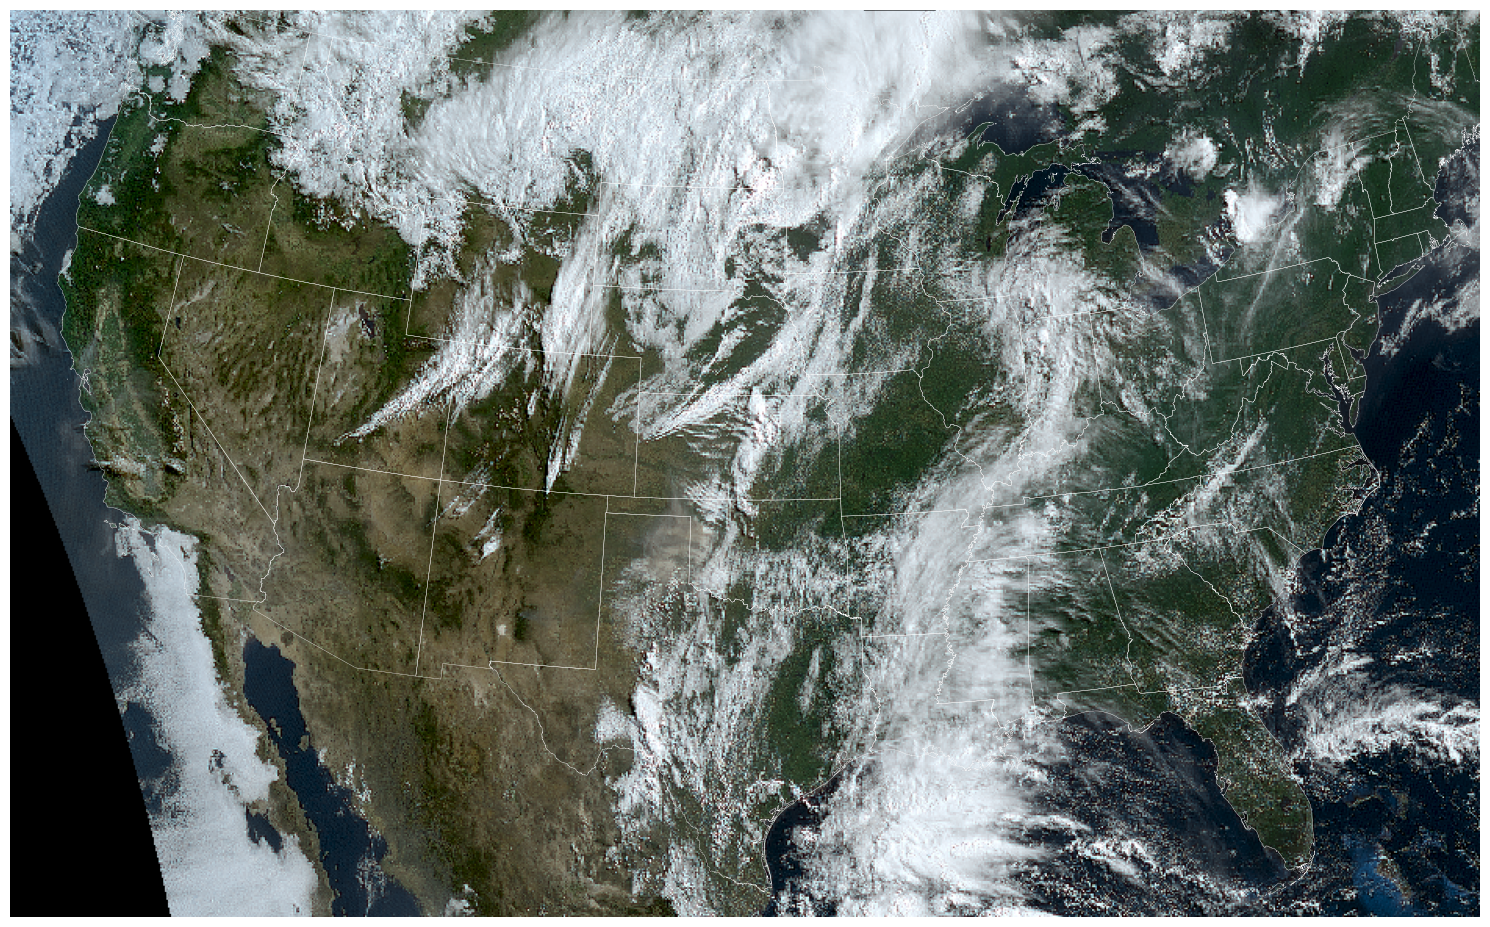

In [10]:
def plot_CONUS(data, crs):
    states = get_states(crs) # ./scripts/helper_functions.py
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=crs)
    plt.imshow(data, transform=crs, extent=crs.bounds, origin='upper')
    states.boundary.plot(ax=ax, edgecolor='white', linewidth=.25)
    plt.axis('off')
    fig.tight_layout()
    #plt.savefig('conus.png')
    plt.show()
plot_CONUS(RGB, crs)

## 4. Subsample the Image

At 2km resolution, the 3-channel CONUS satellite imagery contains 180 million pixels. With an increase in the number of pixels, there is a increase in the computational cost to train/run a machine learning model. For efficiency, we will work with images sized down to ~200,000 pixels but still cover 256 km$^2$.

### 4.1. Define parameters for creating geographically localized imagery

#### 4.1.1. Define how to save data

We save the imagery in tif format that can easily be loaded into a machine learning model (formats such as png require compression/decompression). Coordinate data is saved for plotting.

In [11]:
def save_data(data, band, fn_head):
    tif_fn_data = data_dir + 'data/{}_{}.tif'.format(band, fn_head)
    skimage.io.imsave(tif_fn_data, data)
    print("saved file: {}".format(tif_fn_data))

def save_coords(lat, lon, fn_head):
    tif_fn_coords = data_dir + 'coords/{}.tif'.format(fn_head)
    coords_layers = np.dstack([lat, lon])
    skimage.io.imsave(tif_fn_coords, coords_layers)
    print("saved file: {}".format(tif_fn_coords))

#### 4.1.2. Define center of image

In [11]:
lat = '40.0'
lon = '-105.27'

#### 4.1.3. Define extent around center

In [12]:
def get_extent(lat, lon, res, img_size=256): # img_size - number of pixels
    lcc_proj = pyproj.Proj(get_proj())
    center = lcc_proj(lon,lat)
    dist = int(img_size/2*res)
    x0 = center[0] - dist
    y0 = center[1] - dist
    x1 = center[0] + dist
    y1 = center[1] + dist
    return [x0, y0, x1, y1]

### 4.2. Raw Band Imagery

Each of the single bands from the ABI will be saved to their own individual *.tif file.

In [13]:
def create_raw(sat_fns, lat, lon, res=2000): # res is resolution in km
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0]+'_'+lat+'_'+lon
    extent = get_extent(lat, lon, res)
    bands = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']
    scn = get_scn(sat_fns, bands, extent, res)
    lons, lats = scn[bands[0]].attrs['area'].get_lonlats()
    for band in bands:
        save_data(scn[band].data, band, fn_head)
    save_coords(lats, lons, fn_head)
    return fn_head, scn
    
fn_head, scn = create_raw(sat_fns, lat, lon)

saved file: ./data/data/C01_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C02_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C03_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C04_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C05_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C06_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C07_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C08_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C09_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C10_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C11_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C12_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/C13_

#### 4.2.1. Plot all the raw bands

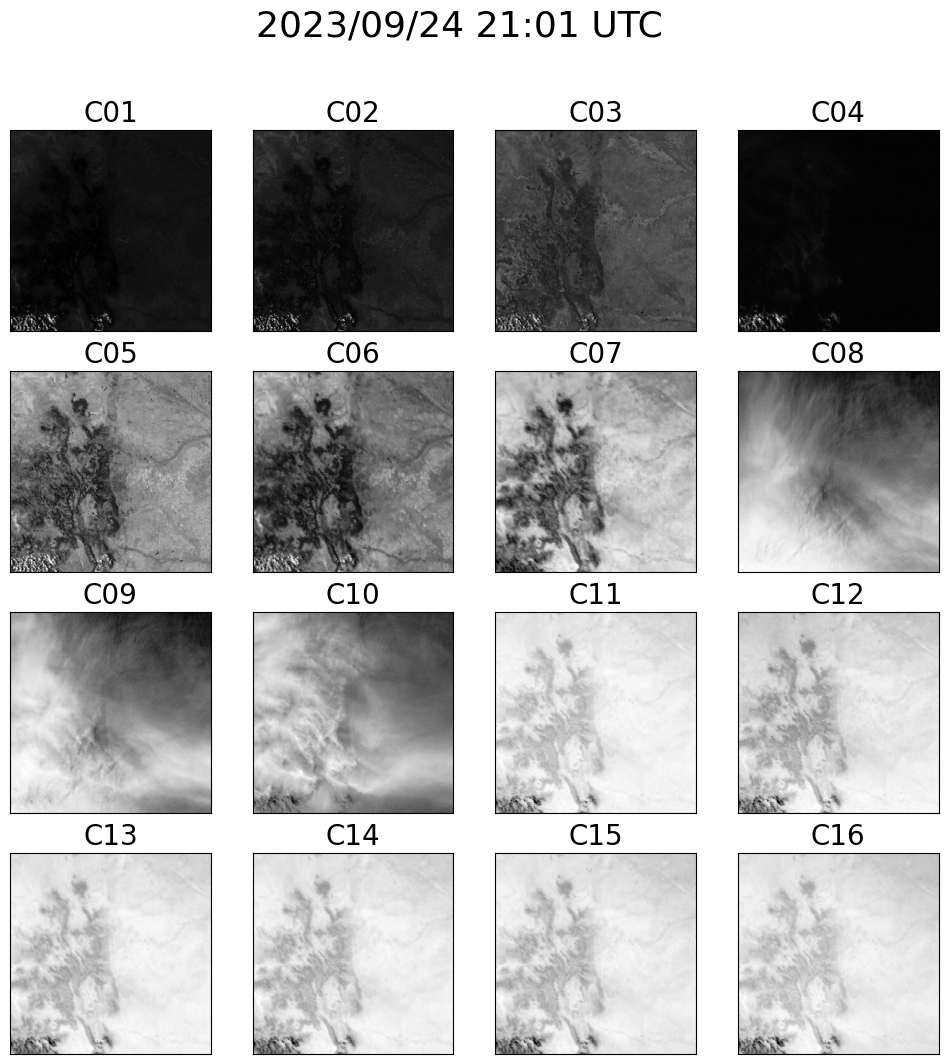

In [14]:
from plot_tifs import * # ./scripts/plot_tifs.py
plot_all_bands(fn_head)

### 4.3. Composites

Each of the spectral bands listed in table 1 convey information about specific features. Combining data from multiple satellite bands can help visualize features, for example, using the near-IR "veggie" band (C03) has a higher contrast in reflectance when that wavelength of light interacts with healthy vegetation.

In [15]:
composites = ['airmass', 'true_color_raw', 'true_color','natural_color']

In [16]:
def create_composite(sat_fns, lat, lon, composites = ['cimss_true_color_sunz_rayleigh', 'airmass'], res=1000):
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0]+'_'+lat+'_'+lon
    extent = get_extent(lat, lon, res)
    scn = get_scn(sat_fns, composites, extent, res)
    for composite in composites:
        data = get_RGB(scn, composite)
        save_data(data, composite, fn_head)
    return fn_head, scn
fn_head, scn = create_composite(sat_fns, lat, lon, composites)

saved file: ./data/data/airmass_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/true_color_raw_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/true_color_G16_s20232672101174_e20232672103547_40.0_-105.27.tif
saved file: ./data/data/natural_color_G16_s20232672101174_e20232672103547_40.0_-105.27.tif


#### 4.3.1. Plot Composites

2023/09/24 21:01 UTC


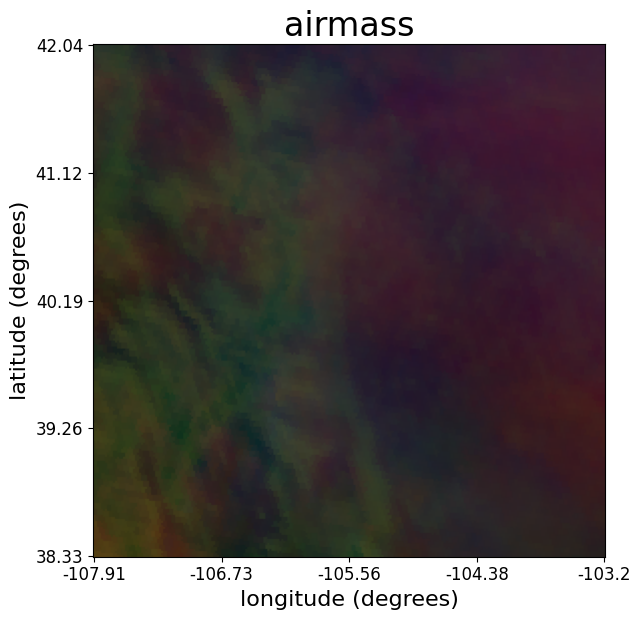

2023/09/24 21:01 UTC


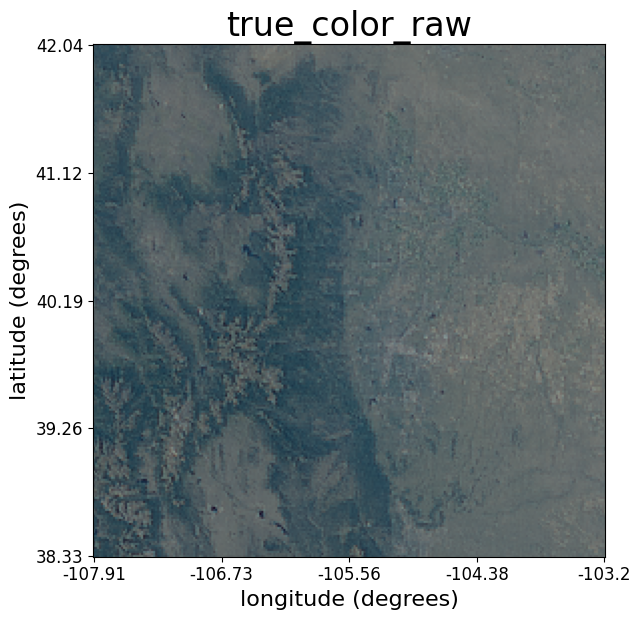

2023/09/24 21:01 UTC


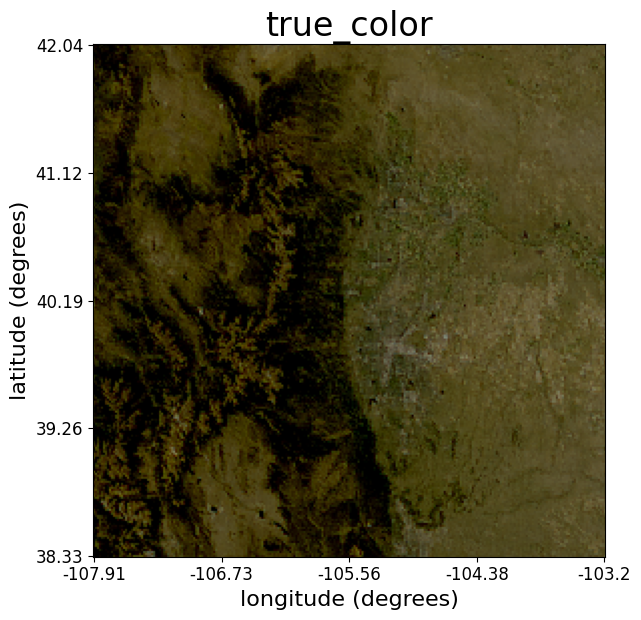

2023/09/24 21:01 UTC


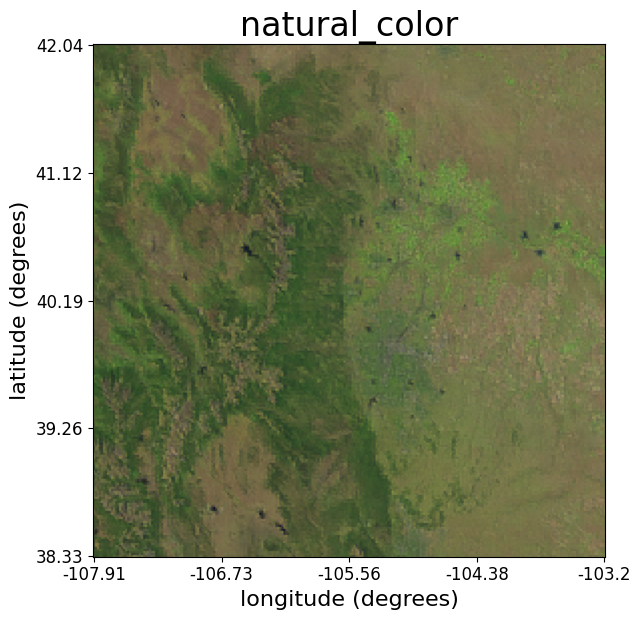

In [17]:
def plot_composite(composite, fn_head, data_loc="./data/"):
    data_fn = glob("{}data/{}_{}*.tif".format(data_loc, composite, fn_head))[0]
    coords_fn = glob("{}coords/{}.tif".format(data_loc, fn_head))[0]
    print(get_datetime_from_fn(coords_fn))
    RGB = skimage.io.imread(data_fn, plugin='tifffile')
    lat, lon = get_lat_lon(coords_fn)
    plt.figure(figsize=(8, 6),dpi=100)
    plt.imshow(RGB)
    plt.yticks(np.linspace(0,RGB.shape[0]-1,len(lat)), np.round(lat,2), fontsize=12)
    plt.ylabel('latitude (degrees)', fontsize=16)
    plt.xticks(np.linspace(0,RGB.shape[0]-1,len(lon)), np.round(lon,2), fontsize=12)
    plt.xlabel('longitude (degrees)', fontsize=16)
    plt.title(composite,fontsize=24)
    plt.tight_layout(pad=0)
    plt.show()

for composite in composites:
    plot_composite(composite, fn_head)